# Tutorial 01: Model-Based Spectral Calibration using LEAP
This tutorial introduces a **model-based spectral calibration** approach using the [LEAP](https://github.com/LLNL/LEAP)
 projector. 

In this tutorial, we will 
- simulate multi-energy dataset using LEAP projector
  - simulate CT scans with specific source, filter, and detector configurations. 
  - scan multiple materials at different source voltages to generate multi-energy dataset. 
- model-based spectral calibration
  - Step 0: Obtain sample masks and calculate forward matrix.
  - Step 1: Configure Source Model
  - Step 2: Configure Filter Model
  - Step 3: Configure Detector Model

## X-ray System Setup

### Source
- **Type**: Reflection
- **Take-off Angle**: 13°
- **Voltages Used for Scanning**:
  - 50 kV
  - 100 kV
  - 150 kV

### Filter
- **Material**: Aluminum (Al)
- **Thickness**: 3 mm

### Detector
- **Material**: Cesium Iodide (CsI)
- **Thickness**: 0.33 mm

### Samples
- **Shapes**: Rods with 0.5 mm radius
- **Materials**: 
  - Vanadium (V)
  - Aluminum (Al)
  - Titanium (Ti)
  - Magnesium (Mg)
- **Height**: 0.2 mm

### CT Geometry
- **Beam Type**: Cone Beam
- **Source-to-Object Distance (SOD)**: 8 mm
- **Source-to-Detector Distance (SDD)**: 15 mm
- **Detector Specifications**:
  - **Pixel Size**: 0.01 mm × 0.01 mm
  - **Resolution**: 50 × 512 pixels
- **Number of Views**: 64

In [1]:
import numpy as np
import matplotlib.pyplot as plt

max_simkV = 180 # keV
takeoff_angle = 13 # degree
voltage_list = [40, 80, 180]
mas_list = [0.1,0.1,0.1]

fltr_mat = 'Al'
fltr_th = 3 # mm

det_mat = 'CsI'
det_density = 4.51 # g/cm^3
det_th = 0.33 # mm

sample_mats = ['V', 'Al', 'Ti', 'Mg']
sample_h = 0.2 # mm
sample_diameter = 0.5 # mm


ct_info = {
    "Geometry": "Cone",
    "SOD": 8,
    "SDD": 15,
    "psize": [0.01875, 0.01875],  # Width and height in mm
    "rsize": [0.01, 0.01],
    "Resolution": [50, 512],     # Rows and columns
    "NViews": 128
}

## A. Simulate multi-energy dataset using LEAP projector

### A01. Ground Truth Source Spectra

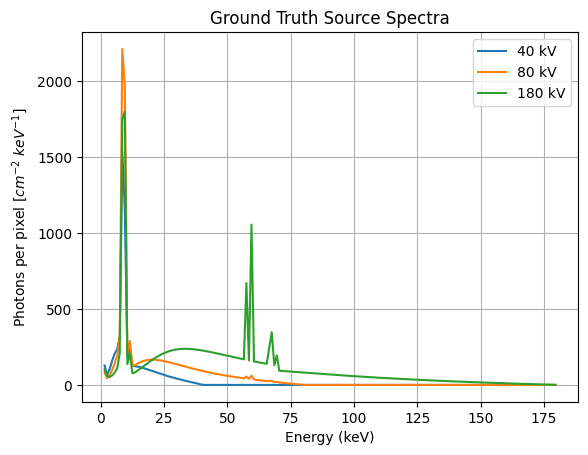

In [2]:
import spekpy as sp

max_simkV = max(voltage_list)
takeoff_angle = 13

# Define energy bins from 1.5 keV up to (max_simkV - 0.5) keV.
energies = np.linspace(1.5, max_simkV - 0.5, max_simkV-1)

# Initialize an empty list to store the generated source spectra.
gt_src_spec_list = []

for case_i, simkV in enumerate(voltage_list):
    # Generate the X-ray spectrum model with Spekpy for each voltage.
    s = sp.Spek(kvp=simkV, th=takeoff_angle, dk=1, z=ct_info['SDD'], mas=mas_list[case_i], char=True)
    k, phi_k = s.get_spectrum(edges=False)  # Retrieve energy bins and fluence spectrum [Photons cm^-2 keV^-1]
    
    # Adjust the fluence for the detector pixel area.
    phi_k = phi_k * ((ct_info['psize'][0] / 10) * (ct_info['psize'][1] / 10))  # Convert pixel size from mm² to cm²

    # Initialize a zero-filled spectrum array with length max_simkV.
    src_spec = np.zeros(max_simkV-1)
    src_spec[:simkV-1] = phi_k  # Assign spectrum values starting from 1.5 keV

    # Add the processed spectrum for this voltage to the list.
    gt_src_spec_list.append(src_spec)

# Convert the list of source spectra to a numpy array for easy handling.
gt_src_spec_list = np.array(gt_src_spec_list)

# Plot each generated source spectrum.
for src_i, gt_src_spec in enumerate(gt_src_spec_list):
    plt.plot(energies, gt_src_spec, label='%d kV' % voltage_list[src_i])

plt.title('Ground Truth Source Spectra')
plt.xlabel('Energy (keV)')
plt.ylabel('Photons per pixel [$cm^{-2}$ $keV^{-1}$]')
plt.grid()
plt.legend()

#### A02. Ground Truth Filter Response

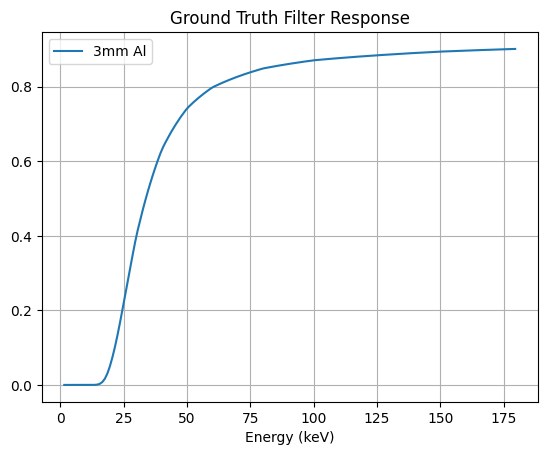

In [3]:
from xspec import get_filter_response
from xspec.chem_consts._periodictabledata import density

gt_fltr = get_filter_response(energies, fltr_mat, density[fltr_mat], fltr_th)

plt.plot(energies, gt_fltr, label='3mm Al')
plt.title('Ground Truth Filter Response')
plt.legend()
plt.xlabel('Energy (keV)')
plt.grid()

### A03. Ground Truth Detector Response

Converted energy from a X-ray photon with energy from 1 to 150 keV. 

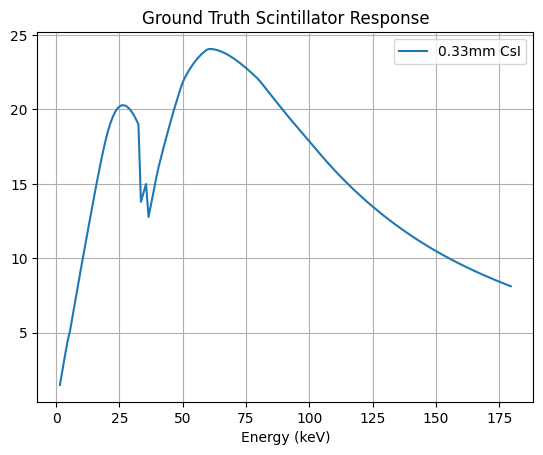

In [4]:
from xspec import get_scintillator_response
from xspec.chem_consts._periodictabledata import density

gt_det = get_scintillator_response(energies, det_mat, det_density, det_th)

plt.plot(energies, gt_det, label='%.2fmm %s'%(det_th, det_mat))
plt.title('Ground Truth Scintillator Response')
plt.legend()
plt.xlabel('Energy (keV)')
plt.grid()

### A04. Linear Attenuation Coefficients of homogenous samples

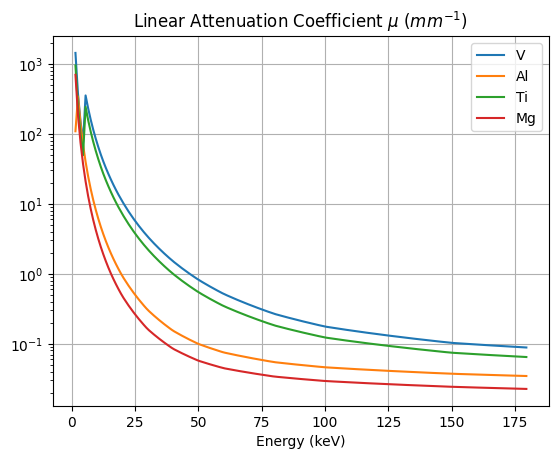

In [5]:
from xspec.chem_consts import get_lin_att_c_vs_E


# Scanned Homogeneous Rods
mat_density = [density['%s' % formula] for formula in sample_mats]
lac_vs_E_list = [get_lin_att_c_vs_E(den, formula, energies) for den, formula in zip(mat_density, sample_mats)]

# Plot LAC
for lac_vs_E,mat in zip(lac_vs_E_list, sample_mats):
    plt.plot(energies, lac_vs_E, label=mat)
plt.yscale('log')
plt.title('Linear Attenuation Coefficient $\mu$ ($mm^{-1}$)')
plt.xlabel('Energy (keV)')
plt.grid()
plt.legend()

### A06. GT X-ray System Spectral Responses

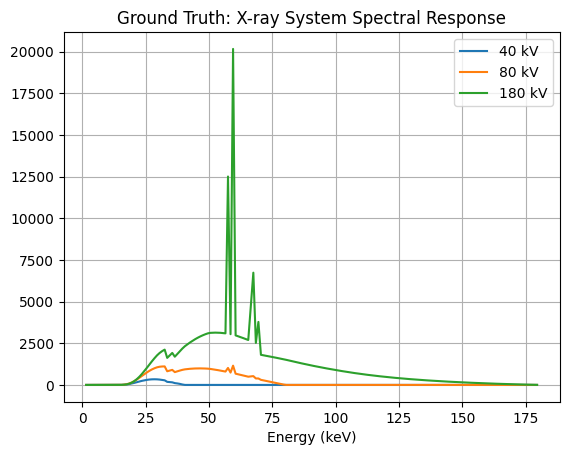

In [6]:
gt_spec_list = [gt_source * gt_fltr  * gt_det for gt_source in gt_src_spec_list]
for spec_i, gt_spec in enumerate(gt_spec_list):
    plt.plot(energies, gt_spec, label='%d kV'%voltage_list[spec_i])
plt.legend()
plt.title('Ground Truth: X-ray System Spectral Response')
plt.xlabel('Energy (keV)')
plt.grid()
plt.legend()

### A06. Masks for 4 homogenous samples

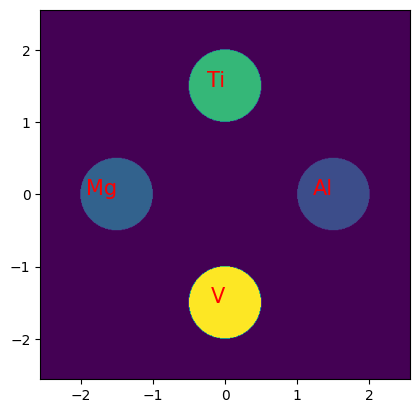

In [7]:
from xspec._utils import Gen_Circle

# Define parameters for 4 cylinders with 0.5mm radius, evenly distributed on a circle with a radius of 1.5mm.
Radius = [0.5 for _ in range(len(sample_mats))]  # Radius of each cylindrical cross-section in mm
arrange_with_radius = 1.5  # Radius of the circle on which cylinder centers are distributed (in mm)

# Calculate center positions for each cylinder, evenly spaced around the circular arrangement
centers = [[np.sin(rad_angle) * arrange_with_radius, np.cos(rad_angle) * arrange_with_radius]
           for rad_angle in np.linspace(-np.pi / 2, -np.pi / 2 + np.pi * 2, len(sample_mats), endpoint=False)]

# Generate 3D masks for each cylinder
mask_list = []
for mat_id, mat in enumerate(sample_mats):
    # Initialize a circular mask generator for 2D slices
    circle = Gen_Circle((ct_info["Resolution"][1], ct_info["Resolution"][1]), 
                        (ct_info["rsize"][0], ct_info["rsize"][1]))
    # Create a 3D mask array for the current cylinder by repeating the circular 2D mask across slices
    mask_3d = np.array([circle.generate_mask(Radius[mat_id], centers[mat_id]) 
                        for i in range(ct_info["Resolution"][0])])
    mask_list.append(mask_3d)

# Below just for display    
# Initialize the phantom array to hold combined cylinder masks
phantom = np.zeros(mask_list[0].shape)    

# Combine all masks into the phantom, weighted by the linear attenuation coefficients for each material
for mat_id, mat in enumerate(sample_mats):
    phantom += mask_list[mat_id] * np.mean(lac_vs_E_list[mat_id])

# Display a slice of the phantom (e.g., 26th slice) to show cross-sectional circles of cylinders
plt.imshow(phantom[25], extent=[-2.56, 2.56, -2.56, 2.56], origin='lower')

# Annotate each circle with its corresponding material name
for mat_id, mat in enumerate(sample_mats):
    plt.text(centers[mat_id][1], centers[mat_id][0], mat, fontsize=15, ha='right', color='red')


### A07. Setup forward projector with LEAP

In [8]:
import time
from leapctype import *

class fw_projector:
    """A class for forward projection using LEAP."""

    def __init__(self, numAngles, numRows, numCols, pixelHeight, pixelWidth, centerRow, centerCol, phis, sod, sdd):
        """
        Initializes the forward projector with specified geometric parameters.
        """
        # Initialize parameters as instance variables
        self.numAngles = numAngles
        self.numRows = numRows
        self.numCols = numCols
        self.pixelHeight = pixelHeight
        self.pixelWidth = pixelWidth
        self.centerRow = centerRow
        self.centerCol = centerCol
        self.phis = phis
        self.sod = sod  # Source-to-object distance
        self.sdd = sdd  # Source-to-detector distance
        self.leapct = tomographicModels()
        self.leapct.about()
    def forward(self, mask):
        """
        Computes the projection of a given mask.

        Parameters:
            mask (numpy.ndarray): 3D mask of the object to be projected.

        Returns:
            numpy.ndarray: The computed projection of the mask.
        """

        self.leapct.set_conebeam(self.numAngles, 
                            self.numRows, 
                            self.numCols, 
                            self.pixelHeight, 
                            self.pixelWidth, 
                            self.centerRow, 
                            self.centerCol, 
                            self.phis, 
                            self.sod, 
                            self.sdd)
        self.leapct.set_default_volume()
        proj = self.leapct.allocate_projections() # shape is numAngles, numRows, numCols
        volume = np.ascontiguousarray(mask.astype(np.float32), dtype=np.float32)
        
        # "Simulate" projection data
        startTime = time.time()
        self.leapct.project(proj,volume)
        print('Forward Projection Elapsed Time: ' + str(time.time()-startTime))
        return proj

leapct2 = tomographicModels()
projector =fw_projector(ct_info['NViews'], 
                        ct_info["Resolution"][0], 
                        ct_info["Resolution"][1], 
                        ct_info["psize"][0], 
                        ct_info["psize"][1], 
                        0.5*(ct_info["Resolution"][0]-1), 
                        0.5*(ct_info["Resolution"][1]-1), 
                        leapct2.setAngleArray(ct_info['NViews'], 360.0), 
                        ct_info["SOD"], 
                        ct_info["SDD"])

### A08 Calculate Attenuation Matrix 

In [9]:
from xspec import calc_forward_matrix
spec_F = calc_forward_matrix(mask_list, lac_vs_E_list, projector)

Forward Projection Elapsed Time: 0.24805855751037598
Forward Projection Elapsed Time: 0.24852371215820312
Forward Projection Elapsed Time: 0.2502455711364746
Forward Projection Elapsed Time: 0.27208805084228516


### A09 Simulate Transmission Data

In [10]:
trans_list = []
for case_i, gt_spec in zip(np.arange(len(gt_spec_list)), gt_spec_list):

     # Add poisson noise.
    trans = np.trapz(spec_F * gt_spec, energies, axis=-1)
    trans_0 = np.trapz(gt_spec, energies, axis=-1)
    trans_noise = np.random.poisson(trans).astype(np.float32)
    trans_noise /= trans_0

    # Store noisy transmission data.
    trans_list.append(trans_noise)

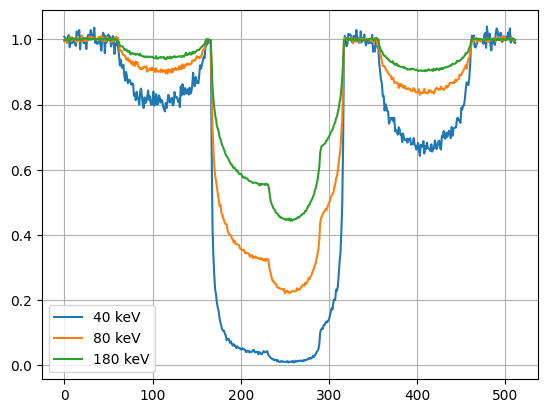

In [11]:
for case_i, gt_spec in zip(np.arange(len(gt_spec_list)), gt_spec_list):
    plt.plot(trans_list[case_i][3, 25], label=f'{voltage_list[case_i]} keV')
plt.legend()
plt.grid()

## B. Spectral Calibration

### B01. FBP Reconstruction using LEAP
FBP Reconstruction with data scanned at 150 keV

In [12]:
leapct = tomographicModels()
leapct.about()

leapct.set_conebeam(ct_info['NViews'], 
                    ct_info["Resolution"][0], 
                    ct_info["Resolution"][1], 
                    ct_info["psize"][0], 
                    ct_info["psize"][1], 
                    0.5*(ct_info["Resolution"][0]-1), 
                    0.5*(ct_info["Resolution"][1]-1), 
                    leapct.setAngleArray(ct_info['NViews'], 360.0), 
                    ct_info["SOD"], 
                    ct_info["SDD"])

leapct.set_default_volume()
sino = -np.log(trans_list[-1]).astype(np.float32)
sino = np.ascontiguousarray(sino, dtype=np.float32) # shape is numAngles, numRows, numCols
recon = leapct.allocate_volume() # shape is numZ, numY, numX
recon[:] = 0.0

startTime = time.time()
#leapct.backproject(g,f)
leapct.FBP(sino,recon)
filters = filterSequence(1.0e0) # filter strength argument must be turned to your specific application
filters.append(TV(leapct, delta=0.02/20.0)) # the delta argument must be turned to your specific application
leapct.RWLS(sino,recon,20,filters,None,'SQS')
print('Reconstruction Elapsed Time: ' + str(time.time()-startTime))

RWLS iteration 1 of 20
	lambda = 1.3301746924151079
RWLS iteration 2 of 20
	lambda = 4.299190004546931
RWLS iteration 3 of 20
	lambda = 1.8250412527129625
RWLS iteration 4 of 20
	lambda = 3.2049738813231428
RWLS iteration 5 of 20
	lambda = 2.1548568127903978
RWLS iteration 6 of 20
	lambda = 2.686887710420725
RWLS iteration 7 of 20
	lambda = 2.236319334296453
RWLS iteration 8 of 20
	lambda = 2.350167761829836
RWLS iteration 9 of 20
	lambda = 2.2666885216689043
RWLS iteration 10 of 20
	lambda = 2.286748099572091
RWLS iteration 11 of 20
	lambda = 2.3010556650696685
RWLS iteration 12 of 20
	lambda = 2.3348729953877068
RWLS iteration 13 of 20
	lambda = 2.3768230910042374
RWLS iteration 14 of 20
	lambda = 2.425039284836427
RWLS iteration 15 of 20
	lambda = 2.4762874513810913
RWLS iteration 16 of 20
	lambda = 2.528564209579099
RWLS iteration 17 of 20
	lambda = 2.579787149458839
RWLS iteration 18 of 20
	lambda = 2.628279840652446
RWLS iteration 19 of 20
	lambda = 2.6731000512643583
RWLS iterat

In [13]:
recon.shape

(50, 512, 512)

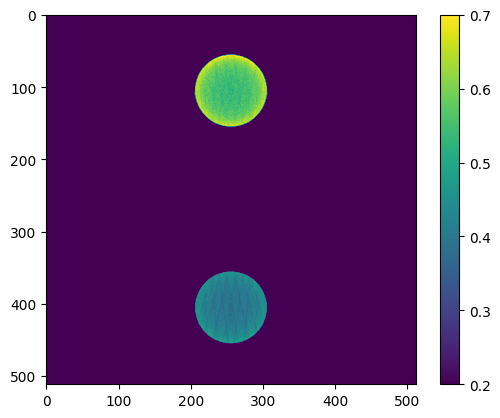

In [14]:
plt.imshow(recon[25])
plt.colorbar()

### B03. Circle Detection (Optional)

In [15]:
from xspec.phantom import detect_hough_circles, segment_object

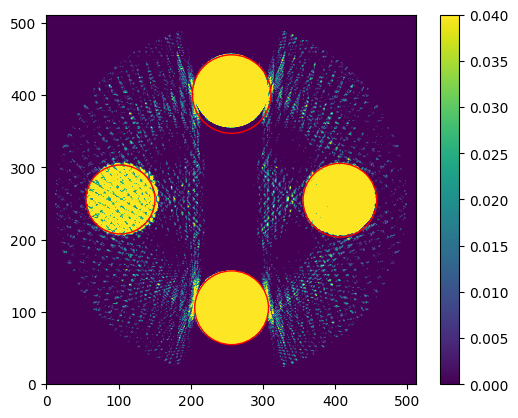

In [16]:
from matplotlib.patches import Circle
import math

plt.imshow(recon[25],vmin=0.00,vmax=0.04,origin='lower')
plt.colorbar()
# Get the current axes.
ax = plt.gca()
circles = detect_hough_circles(recon[25], radius_range=(45, 55), vmin=0.00, vmax=0.02, min_dist=200,HoughCircles_params2=10)
circles = sorted(circles, key=lambda x: math.atan2(x[1]-255.5, x[0]-255.5))
# Create and add circles to the plot.
for x, y, radius in circles:
    circle = Circle((x, y), radius, color='red', fill=False)
    ax.add_patch(circle)

# Optionally set the aspect of the plot to be equal.
# This makes sure that the circles are not skewed.
ax.set_aspect('equal')

# Show the plot with the circles.
plt.show()

### B04. Segment Object to get 3D Mask

In [17]:
est_mask_list = []
bbox_half_size = int(np.mean([cir[2] for cir in circles])*1.1)
vmin_list = [0.02,0.01,0.2,0.01]
vmax_list = [0.4,0.02,0.7,0.02]
# Loop through each slice to get 3D mask.
for vi,cir in enumerate(circles):
    xcenter, ycenter, r = cir
    # Segment object with 3D mask
    # Set different vmin and vmax for different samples.
    # Set bbox to restrict a box region for object segmentation.
    est_mask = [segment_object(
        recon[i], 
        vmin_list[vi], 
        vmax_list[vi], 
        10, # Canny sigma in canny edge detection. Larger value is more possible to connect to a line.
        roi_radius=None,
        bbox=(
            int(ycenter - bbox_half_size),
            int(xcenter - bbox_half_size),
            int(ycenter + bbox_half_size),
            int(xcenter + bbox_half_size)
        )) for i in range(len(recon))]
    est_mask_list.append(np.array(est_mask))


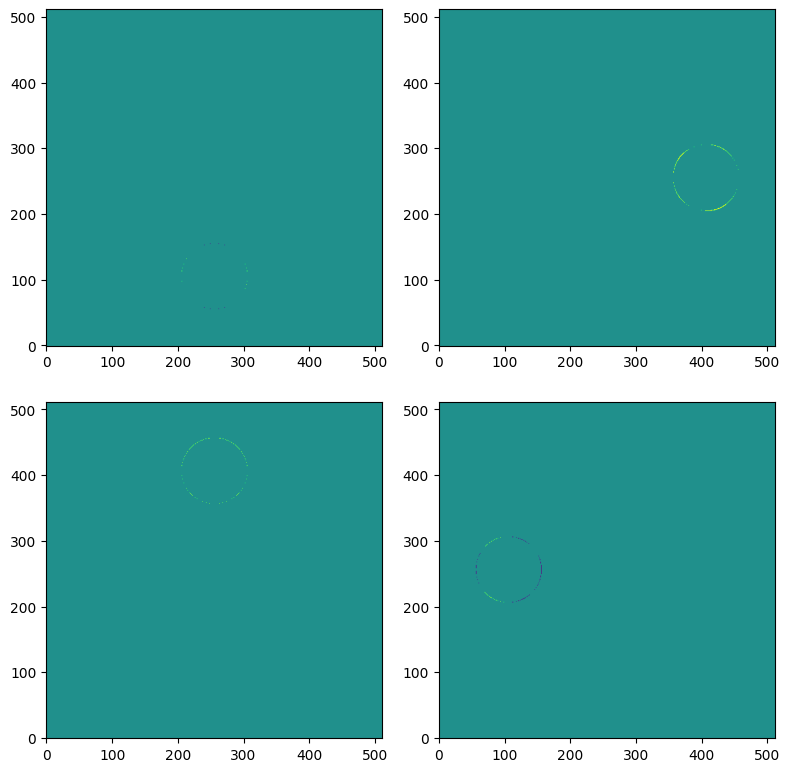

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for j in range(len(est_mask_list)):
    ax = axs.flat[j]
    est_mask = est_mask_list[j]
    gtmask = mask_list[(j)%len(est_mask_list)]
    # Display the image
#     ax.imshow(est_mask[25],origin='lower')
    ax.imshow(est_mask[25].astype('float32')-gtmask[25].astype('float32'),vmin=-1,vmax=1,origin='lower')
# Adjust the layout
plt.tight_layout()
plt.show()

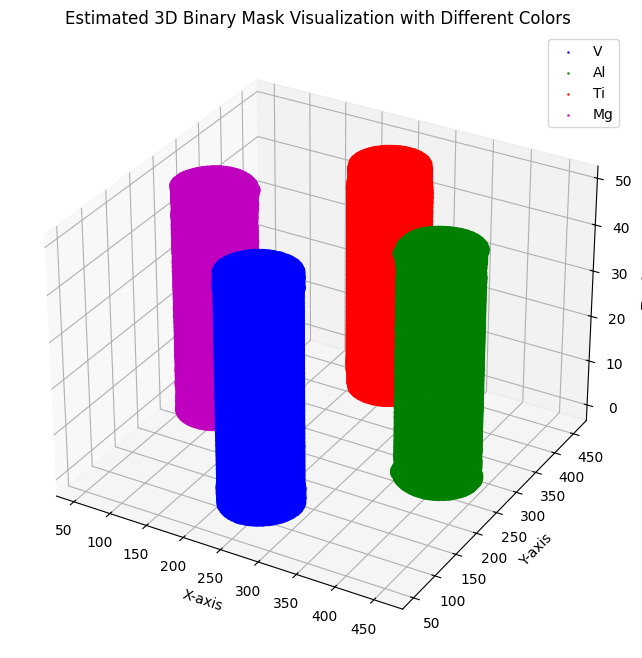

In [19]:
# Define colors for each mask
colors = ['b', 'g', 'r', 'm']  # Blue, Green, Red, Magenta for each est_mask

# Plot the 3D masks using a scatter plot with different colors
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for i, est_mask in enumerate(est_mask_list):
    # Get the coordinates of the points where the mask is 1
    z, y, x = np.where(est_mask == 1)
    ax.scatter(x, y, z, color=colors[i], marker='o', s=1, alpha=0.7, label=sample_mats[i])

# Set labels and title
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Estimated 3D Binary Mask Visualization with Different Colors")
plt.legend()
plt.show()

### B05. Calculate Forward Matrix with Estimated 3D Masks

In [20]:
# Only use 8 different views for spectral calibration
NViews_For_MBSC = 8
projector2 =fw_projector(NViews_For_MBSC, 
                        ct_info["Resolution"][0], 
                        ct_info["Resolution"][1], 
                        ct_info["psize"][0], 
                        ct_info["psize"][1], 
                        0.5*(ct_info["Resolution"][0]-1), 
                        0.5*(ct_info["Resolution"][1]-1), 
                        leapct.setAngleArray(ct_info['NViews'], 360.0)[:NViews_For_MBSC], 
                        ct_info["SOD"], 
                        ct_info["SDD"])

In [21]:
est_spec_F = calc_forward_matrix(est_mask_list, lac_vs_E_list, projector2)

Forward Projection Elapsed Time: 0.1771242618560791
Forward Projection Elapsed Time: 0.12029790878295898
Forward Projection Elapsed Time: 0.1189415454864502
Forward Projection Elapsed Time: 0.11914730072021484


### B06. X-ray System Model Configuration

In [22]:
from xspec.models import Reflection_Source, Filter, Scintillator
from xspec.defs import Material

In [23]:
# Use Spekpy to generate a source spectra dictionary.
takeoff_angles = np.linspace(5,45,11)
src_spec_list = []
for case_i,simkV in enumerate(voltage_list):
    for ta in takeoff_angles:
        # Generate the X-ray spectrum model with Spekpy for each voltage.
        s = sp.Spek(kvp=simkV, th=ta, dk=1, z=ct_info['SDD'], mas=mas_list[case_i], char=True)
        k, phi_k = s.get_spectrum(edges=False)  # Retrieve energy bins and fluence spectrum [Photons cm^-2 keV^-1]

        # Adjust the fluence for the detector pixel area.
        phi_k = phi_k * ((ct_info['psize'][0] / 10) * (ct_info['psize'][1] / 10))  # Convert pixel size from mm² to cm²

        # Initialize a zero-filled spectrum array with length max_simkV.
        src_spec = np.zeros(max_simkV-1)
        src_spec[:simkV-1] = phi_k  # Assign spectrum values starting from 1.5 keV

        # Add the processed spectrum for this voltage to the list.
        src_spec_list.append(src_spec)

src_spec_list = np.array(src_spec_list)
src_spec_list = src_spec_list.reshape((len(voltage_list),len(takeoff_angles),-1))

In [24]:
# Configure Source Model
# Source voltage is not estimated.
# Takeoff angle is estimated in range [5,45] with inital value 25 degree.
sources = [Reflection_Source(voltage=(voltage, None, None), takeoff_angle=(25, 5, 45), single_takeoff_angle=True)
           for voltage in voltage_list]
for src_i, source in enumerate(sources):
    source.set_src_spec_list(energies, src_spec_list, voltage_list, takeoff_angles)

In [31]:
# Configure Filter Model
# Knowns: Use one filter for both scans.
# Possible filter materials: Al and Cu.
psb_fltr_mat = [Material(formula='Al', density=2.702), 
                Material(formula='Cu', density=8.92)]
filter_1 = Filter(psb_fltr_mat, thickness=(5, 0, 10))

# Configure Scintillator Model
# Knowns: Use one scintillator for both scans.
# Possible scintillator materials
scint_params_list = [
    {'formula': 'CsI', 'density': 4.51},
    {'formula': 'Gd3Al2Ga3O12', 'density': 6.63},
    {'formula': 'Lu3Al5O12', 'density': 6.73},
    {'formula': 'CdWO4', 'density': 7.9},
    {'formula': 'Y3Al5O12', 'density': 4.56},
    {'formula': 'Bi4Ge3O12', 'density': 7.13},
    {'formula': 'Gd2O2S', 'density': 7.32}
]
psb_scint_mat = [Material(formula=scint_p['formula'], density=scint_p['density']) for scint_p in scint_params_list]
scintillator_1 = Scintillator(materials=psb_scint_mat, thickness=(0.25, 0.01, 0.5))

# For each scan using a different source voltage, we define a different total spectral model.
# Each spectral model is a list containing source, filters, and scintillator models. 
# Allow filter_1, ..., filter_n.
spec_models = [[source, filter_1, scintillator_1] for source in sources]

### B07. Spectral Calibration with Simulated Multi-Energy Data

In [32]:
# Build Training Set
# Use first 8 views and center 2 slices.
train_rads = [trans[:8,10:-10:10] for trans in trans_list]

# Assume a same forward matrix for different scans at different voltages.
forward_matrices = [est_spec_F[:,10:-10:10] for i in range(len(voltage_list))]

print("Training Measurement Shape: \n", train_rads[0].shape,train_rads[1].shape,train_rads[2].shape)
print("Training Forward Matrix Shape: \n",forward_matrices[0].shape,forward_matrices[1].shape,forward_matrices[2].shape)

Training Measurement Shape: 
 (8, 3, 512) (8, 3, 512) (8, 3, 512)
Training Forward Matrix Shape: 
 (8, 3, 512, 179) (8, 3, 512, 179) (8, 3, 512, 179)


In [ ]:
from xspec.estimate import Estimate

learning_rate = 0.01
max_iterations = 5000
stop_threshold = 1e-6
optimizer_type = 'NNAT_LBFGS' # Can also use Adam.

Estimator = Estimate(energies)
for nrad, forward_matrix, concatenate_models in zip(train_rads, forward_matrices, spec_models):
    Estimator.add_data(nrad, forward_matrix, concatenate_models, weight=None)

# Fit data
Estimator.fit(learning_rate=learning_rate,
              max_iterations=max_iterations,
              stop_threshold=stop_threshold,
              optimizer_type=optimizer_type,
              loss_type='transmission',
              logpath=None,
              num_processes=14)

2024-10-29 15:04:20,268  - Start Estimation.
2024-10-29 15:04:20,270  - Start Estimation.
2024-10-29 15:04:20,269  - Start Estimation.
2024-10-29 15:04:20,271  - Start Estimation.
2024-10-29 15:04:20,272  - Start Estimation.
2024-10-29 15:04:20,273  - Start Estimation.
2024-10-29 15:04:20,277  - Start Estimation.
2024-10-29 15:04:20,277  - Start Estimation.
2024-10-29 15:04:20,277  - Start Estimation.
2024-10-29 15:04:20,278  - Start Estimation.
2024-10-29 15:04:20,279  - Start Estimation.
2024-10-29 15:04:20,281  - Start Estimation.
2024-10-29 15:04:20,282  - Start Estimation.
2024-10-29 15:04:20,283  - Start Estimation.
2024-10-29 15:04:20,423  - Initial cost: 1.552949e-01
2024-10-29 15:04:20,430  - Initial cost: 5.356771e-03
2024-10-29 15:04:20,430  - Initial cost: 1.539085e-01
2024-10-29 15:04:20,436  - Initial cost: 2.966192e-03
2024-10-29 15:04:20,437  - Initial cost: 1.899509e-03
2024-10-29 15:04:20,439  - Initial cost: 1.550032e-01


Number of cases for different discrete parameters: 14


2024-10-29 15:04:20,446  - Initial cost: 1.539539e-01
2024-10-29 15:04:20,452  - Initial cost: 1.539550e-01
2024-10-29 15:04:20,457  - Initial cost: 1.508362e-01
2024-10-29 15:04:20,466  - Initial cost: 1.531864e-01
2024-10-29 15:04:20,476  - Initial cost: 1.037920e-03
2024-10-29 15:04:20,482  - Initial cost: 2.376729e-03
2024-10-29 15:04:20,482  - Initial cost: 1.829190e-03
2024-10-29 15:04:20,482  - Initial cost: 2.151222e-03
2024-10-29 15:04:22,897  - Iteration: 5
2024-10-29 15:04:22,921  - Iteration: 5
2024-10-29 15:04:22,979  - Iteration: 5
2024-10-29 15:04:22,993  - Iteration: 5
2024-10-29 15:04:23,222  - Iteration: 5
2024-10-29 15:04:23,392  - Iteration: 5
2024-10-29 15:04:23,405  - Iteration: 5
2024-10-29 15:04:23,410  - Cost: 0.004811005666851997
2024-10-29 15:04:23,411  - Filter_3_material: Material(formula='Al', density=2.702)
2024-10-29 15:04:23,412  - Filter_3_thickness: 5.381373882293701
2024-10-29 15:04:23,413  - Reflection_Source_1_voltage: 40.0
2024-10-29 15:04:23,413 

2024-10-29 15:04:26,294  - 


### B08. Result Analysis

In [28]:
est_sp = Estimator.get_spectra()

In [29]:
Estimator.get_params()

{'Reflection_Source_1_voltage': tensor(40.),
 'Reflection_Source_takeoff_angle': tensor(16.4853, grad_fn=<ClampFunctionBackward>),
 'Filter_2_material': Material(formula='Al', density=2.702),
 'Filter_2_thickness': tensor(3.2635, grad_fn=<ClampFunctionBackward>),
 'Scintillator_2_material': Material(formula='CsI', density=4.51),
 'Scintillator_2_thickness': tensor(0.3574, grad_fn=<ClampFunctionBackward>),
 'Reflection_Source_2_voltage': tensor(80.),
 'Reflection_Source_3_voltage': tensor(180.)}

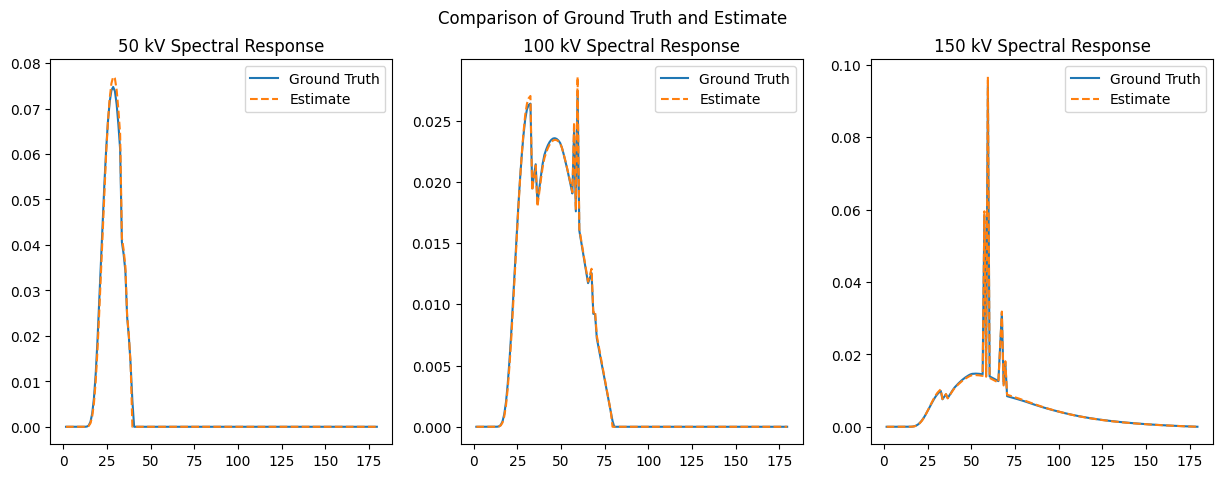

In [30]:
est_sp = Estimator.get_spectra()
res_params = Estimator.get_params()

# Function to print a section of the table
def print_params(params):
    with (torch.no_grad()):
        for key, value in sorted(params.items()):
            if isinstance(value, tuple):
                print(f"{key}: {value[0].numpy()}")
            else:
                print(f"{key}: {value}")
        print()



# Create a figure and axes objects for the subplot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot each subplot
for i in range(3):
    ax = axs[i]
    with torch.no_grad():
        ax.plot(energies, gt_spec_list[i]/np.trapz(gt_spec_list[i],energies),
                label='Ground Truth')
        es = est_sp[i].numpy()
        es /= np.trapz(es,energies)
        ax.plot(energies, es, '--', label='Estimate')

    # Add legend
    ax.legend()

    # Add subplot title
    ax.set_title(f'{[50, 100, 150][i]} kV Spectral Response')

# Add common title
fig.suptitle('Comparison of Ground Truth and Estimate')

# Show the plot
plt.show()